# Setup

## Import necessary packages

In [ ]:
# Import necessary packages
import flopy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle

## Define needed functions

In [ ]:
# Define needed functions
def change_type(df, cols, t):
    """
    Change the dtype of selected columns to a given type

    df: pandas.DataFrame
        the dataframe
    cols: str, list of str
        the columns to be changed
    t: str
        the dtype wanted

    Returns:
    df: pandas.DataFrame
    """
    for col in cols:
        df[col] = df[col].astype(t)
    return df

def load_streamflow_dat(f, nsp = 1):
    """
    Load the streamflow.dat file generated as output by MODFLOW

    f: str
        path to the streamflow.dat file
    nsp: int, optional
        number of stress periods of the simulation. 1 works also with stationary models.
        Default is 1
        The option is not yet developed
    
    Returns:
    df: pandas.DataFrame
        dataframe containing the information stored inside streamflow.dat file
    """
    if nsp == 1:
        df = pd.DataFrame()
        with open(f, 'r') as file:
            for row in file.readlines()[8:]:
                r = list(filter(None, row.split(' ')))
                df = pd.concat([df, pd.DataFrame(r).transpose()])
            df.columns = ['l', 'r', 'c', 'iseg', 'ireach', 'flow_into_reach', 'flow_to_aquifer', 'flow_out_reach', 'overlnd_runoff',
                        'direct_precip', 'stream_et', 'stream_head', 'stream_depth', 'stream_width', 'streambed_cond', 'streambed_gradient']
            df.streambed_gradient = df.streambed_gradient.str.removesuffix('\n')
            df = change_type(df, ['l', 'r', 'c', 'iseg', 'ireach'], 'int') 
            df = change_type(df, ['flow_into_reach', 'flow_to_aquifer', 'flow_out_reach', 'overlnd_runoff',
                                    'direct_precip', 'stream_et', 'stream_head', 'stream_depth', 'stream_width',
                                    'streambed_cond', 'streambed_gradient'], 'float')
            df.reset_index(inplace = True, drop= True)
    else:
        for sp in range(nsp):
            pass
    return df

def find_cond(tool, t, tseg, seg_t, reach_t):
        """
        tool:
            the tool variable defined in this if structure
        t: bool
            if True, the condition found refers to the "testa"
            if False, the condition found refers to the "asta"
        tseg:
            the tseg variable defined before
        """
        if tseg:
            if t:
                cond = tool.iseg == seg_t
            else:
                cond = tool.iseg != seg_t
        else:
            if t:
                cond = (tool.iseg == seg_t) & (tool.ireach <= reach_t)
            else:
                cond = (tool.iseg == seg_t) & (tool.ireach > reach_t)
        return cond

## Define needed paths and model name

In [5]:
cwd = os.getcwd()
sfr_data = os.path.join(cwd, 'test_files', 'busca_sfr2_sfr_data.xlsx') # SFR characteristics
model_ws = os.path.join(cwd, 'test_files', 'sfr_model_test') # Model working directory
model_name = 'busca_sfr2'
# Create the output folder
if not os.path.exists(os.path.join(model_ws, 'run_output')):
    os.makedirs(os.path.join(model_ws, 'run_output'))

## Load SFR characteristics

In [6]:
# Load general parameters (item 1)
it1 = pd.read_excel(sfr_data, sheet_name = 'ITEM1')

# Load reach data (item 2)
reach_data = pd.read_excel(sfr_data, sheet_name = 'ITEM2')
reach_data = reach_data.apply(pd.to_numeric)
reach_data.columns = ['k', 'i', 'j', 'iseg', 'ireach', 'rchlen', 'strtop', 'slope',  'strthick',  'strhc1']
reach_data = reach_data.loc[:,:].to_records(index = False)
# flopy adds 1 to layer, row and column, so remove 1 here
reach_data.k = reach_data.k - 1
reach_data.i = reach_data.i - 1
reach_data.j = reach_data.j - 1

# Load item 5
it5 = pd.read_excel(sfr_data, sheet_name = 'ITEM5')

# Load segment data (item 6a)
segment_data = pd.read_excel(sfr_data, sheet_name = 'ITEM6abc')
segment_data.columns = [x.lower() for x in segment_data.columns]
segment_data = segment_data.loc[:,:].to_records(index = False)
segment_data = {0: segment_data}

# Generate the SFR package through flopy
unit_number = 27 # define this based on the model

m = flopy.modflow.Modflow(model_name, model_ws = model_ws)
sfr = flopy.modflow.ModflowSfr2(
    m,
    nstrm = it1.NSTRM.values[0],              # number of reaches
    nss = it1.NSS.values[0],                  # number of segments
    const = it1.CONST.values[0],              # constant for manning's equation: 1 for m/s
    dleak = it1.DLEAK.values[0],              # closure tolerance for stream stage computation
    ipakcb = it1.ISTCB1.values[0],            # flag for writing SFR output to cell-by-cell budget (on unit 50)
    istcb2 = it1.ISTCB2.values[0],            # flag for writing SFR output to text file
    dataset_5 = {0: it5.values[0].tolist()},
    unit_number = unit_number,
    isfropt = it1.ISFROPT.values[0],
    segment_data = segment_data,
    reach_data=reach_data
)

## Define SFR parameters

In [18]:
# Define the type of SFR structure
# 2SEG: 1 segment, the "testa" (the "head" of the fontanile) and the "asta" (the channel of the fontanile) are specified by the reach number in reach_t
# nSEG: n segments, one for the "testa", multiple for the "asta"
sfr_type = 'nSEG'

# Define the segment number of the "testa" and the number of segments of the "asta"
seg_t = 1               # segment number
seg_a = [1,2,3,4,5,6,7] # number of segments of the asta
tseg = False             # True: the "head" takes the whole seg_t, False: the "head" takes a subset of seg_t, specify the reaches of the "head" in reach_t
reach_t = 9             # reach number of the last reach of the "head"

# Define k and slope parameters
k_dict = {
    'kt': 0.0001, 
    'ka': 0.0003
}

# s_dict = {
#     'st': 0.00001,
#     'sa': 0.00005
# }

s_dict = {
    'st': 0.00001,
    'sa': [0.00005,
           0.00005,
           0.00005,
           0.00005,
           0.00005,
           0.00005,
           0.00005]
}

## Define other parameters

In [21]:
# Define reach and segment from where to get the reach flow
reach = 72
segment = 1

# Define the target values for flow and depth
flow_target = 0.0506  # m3/s
depth_target = 0.40   # m

# Set the print of model runs to silent
silent = False # True: the MODFLOW runs will not be printed in the terminal

# Run

In [69]:
params = []
if sfr_type == '2SEG':
    columns = ['m_code', 'kt','ka', 'st', 'sa', 'flow_out_reach', 'stream_depth']

    tool = pd.DataFrame(reach_data)
    tool.loc[find_cond(tool, True, tseg, seg_t, reach_t), 'strhc1'] = k_dict['kt']
    tool.loc[find_cond(tool, False, tseg, seg_t, reach_t), 'strhc1'] = k_dict['ka']
    tool.loc[find_cond(tool, True, tseg, seg_t, reach_t), 'slope'] = s_dict['st']
    tool.loc[find_cond(tool, False, tseg, seg_t, reach_t), 'slope'] = s_dict['sa']

    params = [k_dict['kt'], k_dict['ka'], s_dict['st'], s_dict['sa']]

elif sfr_type == 'nSEG':
    columns = ['kt','ka', 'st'] + [f'sa{x}' for x in range(1, len(seg_a)+1)] + ['flow_out_reach', 'stream_depth']

    tool = pd.DataFrame(reach_data)
    if not tseg:
        tool.loc[(tool.iseg == seg_t) & (tool.ireach <= reach_t), 'strhc1'] = k_dict['kt']
        tool.loc[(tool.iseg == seg_t) & (tool.ireach > reach_t), 'strhc1'] = k_dict['ka']
        tool.loc[(tool.iseg == seg_t) & (tool.ireach <= reach_t), 'slope'] = s_dict['st']
    else:
        tool.loc[tool.iseg == seg_t, 'strhc1'] = k_dict['kt']
        tool.loc[tool.iseg == seg_t, 'slope'] = s_dict['st']
    
    tool.loc[tool.iseg != seg_t, 'strhc1'] = k_dict['ka']

    for sa, seg in zip(s_dict['sa'], seg_a):
        if seg == seg_t and not tseg:
            tool.loc[(tool.iseg == seg) & (tool.ireach > reach_t), 'slope'] = sa
        else:
            tool.loc[tool.iseg == seg, 'slope'] = sa
    params = [k_dict['kt'], k_dict['ka'], s_dict['st']] + s_dict['sa']

reach_data = tool.loc[:,:].to_records(index = False)
sfr.reach_data = reach_data
sfr.write_file()
# Run the model
# m_code = f'M{i}'
success, buff = flopy.mbase.run_model(
            exe_name = os.path.join(model_ws, 'MF2005.exe'),
            namefile = f'{model_name}.nam',
            model_ws = model_ws,
            silent = silent #False to test the code, then switch to True
            )
if not success:
    raise Exception("MODFLOW did not terminate normally.")

# Load the streamflow.dat file
df = load_streamflow_dat(os.path.join(model_ws, f'{model_name}_streamflow.dat'))

# Extract flow and depth in the target reach
f = df.loc[(df.ireach == reach) & (df.iseg == segment), 'flow_out_reach'].values[0]
d = df.loc[(df.ireach == reach) & (df.iseg == segment), 'stream_depth'].values[0]

params.append(f)
params.append(d)
# Extract flow and depth in all reaches and add them to the output structures
flow_rch = df.flow_out_reach
depth_rch = df.stream_depth
flowaq_rch = df.flow_to_aquifer

print('\n\n')
print('Model parameters')
params = pd.DataFrame(params, index=columns, columns=['value']).transpose()
print(params)
print('\nQ difference: ', params.flow_out_reach.values[0] - flow_target, ' m3/s')
print('Height difference: ', params.stream_depth.values[0] - depth_target, ' m')

FloPy is using the following executable to run the model: MF2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: busca_sfr2.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/12/07  1:21:26

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2024/12/07  1:21:27
 Elapsed run time:  0.365 Seconds

  Normal termination of simulation



Model parameters
           kt      ka       st      sa1      sa2      sa3      sa4      sa5  \
value  0.0001  0.0003  0.00001  0.00005  0.00005  0.00005  0.00005  0.00005   

           sa6      sa7  flow_out_reach  stream_depth  
value  0.00005  0.00005         0.11455        0.3283  

Q difference:  0.06395  m3/s
Height difference:  -0.07170000000000004  m


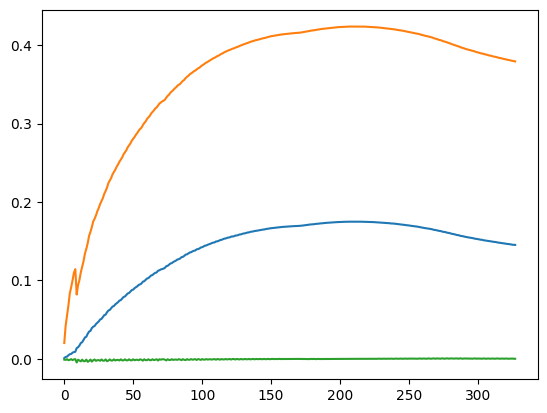

In [ ]:
# plot reach-by-reach information
fig, ax = plt.subplots(1,1)

ax.plot(flow_rch)
ax.plot(depth_rch)
ax.plot(flowaq_rch)

## Save the results

In [ ]:
# save the results
params.to_csv('model_parameters.csv', index=False)
pd.concat([tool.ireach, tool.iseg, flow_rch,depth_rch,flowaq_rch], axis = 1).to_csv('reach_data.csv', index=False)

,ireach,iseg,flow_out_reach,stream_depth,flow_to_aquifer
0,1,1,0.000978,0.02017,-0.000978
1,2,1,0.002375,0.04225,-0.001397
2,3,1,0.002825,0.05497,-0.000450
3,4,1,0.004576,0.06794,-0.001751
4,5,1,0.005840,0.08340,-0.001264
...,...,...,...,...,...
323,45,7,0.146250,0.38090,0.000230
324,46,7,0.145900,0.38040,0.000350
325,47,7,0.145550,0.37990,0.000352
326,48,7,0.145430,0.37950,0.000115
